## 講座2の写経
https://www.youtube.com/watch?v=Cy-CzIMBUDM

In [10]:
import os

import pandas as pd
import numpy as np
from glob import  glob

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
input_dir = '/src/atmacup/atmacup11/data/inputs/'
photo_dir = os.path.join(input_dir, 'photos')
photo_pathes = glob(os.path.join(photo_dir, "*.jpg"))
output_dir = '/src/atmacup/atmacup11/data/outputs/'

os.makedirs(output_dir, exist_ok=True)

train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

In [12]:
import re

#pip install ipynb-path
import ipynb_path

class Config:
    N_FOLDS = 1
    N_EPOCHS = 10
    NB_NAME = ''.join(re.findall('.*/(.*).ipynb', ipynb_path.get()))

### 画像データの読み込み

In [13]:
from PIL import Image

def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

## seedの固定

In [14]:
import torch
import random

def seed_torch(seed=1993):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [15]:
import sklearn
print(sklearn.__version__)

1.0.dev0


In [16]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils import data

# torchvision
from torchvision import transforms as T
from torchvision.models import resnet34

# scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# 1.0.dev0のバーションから使えるようになった
from sklearn.model_selection import StratifiedGroupKFold

In [17]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります
            
            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = (224, 224)

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.RandomResizedCrop(size),
            ]
        )

        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.meta_df)

In [18]:
# CUDA を使うので確認. google colab の場合 GPU accelerator をオンにしておいてください
assert torch.cuda.is_available()

DEVICE = torch.device("cuda")

## Train / Validation Phase

In [19]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()
    
    criterion = nn.MSELoss()
    
    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()
    
    predicts = []
    
    for x_i, y_i in loader:
        
        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""    
    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """
    
    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)
    return score, pred

## Run Fold

1. train / valid の loader 作成
2. 以下を epoch 数だけ繰り返す
    1. 学習用データで学習 
    2. 検証用データで検証スコアの算出

In [20]:
def run_fold(
    model: nn.Module,
    train_df: pd.DataFrame,
    valid_df: pd.DataFrame,
    y_valid: np.ndarray,
    n_epochs=30
) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """
    
    # 0: 
    #   : 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4
    )
    
    #   : 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=4)
    
    # optimizer の定義
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')
        
        # 1: 学習用データで学習を実行。学習時のロスを取得
        train(model, optimizer, train_loader)
        
        # 2: 検証データでのスコアを計算
        score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)
        
        print(score_valid)

### その他

モデル作成などの関数定義

In [21]:
def create_model():
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return model

def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)
    
    if "target" in input_df:
        out_df["target"] = input_df["target"]
        
    return out_df

def run_test_predict(model):
    test_meta_df = create_metadata(test_df)
    
    # 学習時のデータ拡張はオフにしたいので is_train=False としている
    test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)
    
    y_pred = predict(model, loader=test_loader)
    return y_pred

## おさらい

前回の学習のコード

In [22]:
train_meta_df = create_metadata(train_df)
train_meta_df

,object_id,object_path,target
0,002bff09b09998d0be65,/src/atmacup/atmacup11/data/inputs/photos/002b...,1
1,00309fb1ef05416f9c1f,/src/atmacup/atmacup11/data/inputs/photos/0030...,3
2,003a1562e97f79ba96dc,/src/atmacup/atmacup11/data/inputs/photos/003a...,3
3,004890880e8e7431147b,/src/atmacup/atmacup11/data/inputs/photos/0048...,2
4,00718c32602425f504c1,/src/atmacup/atmacup11/data/inputs/photos/0071...,3
...,...,...,...
3932,ffa3259fff8e6f3818a1,/src/atmacup/atmacup11/data/inputs/photos/ffa3...,3
3933,ffd4d361756587883e48,/src/atmacup/atmacup11/data/inputs/photos/ffd4...,1
3934,ffd794b7b311b7b7fd92,/src/atmacup/atmacup11/data/inputs/photos/ffd7...,2
3935,ffe49bba69d06446de7e,/src/atmacup/atmacup11/data/inputs/photos/ffe4...,3


In [23]:
fold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1993)
#cv = list(fold.split(X=train_df, y=train_df['target']))[:Config.N_FOLDS]
cv = list(fold.split(X=train_df, y=train_df['target']))[:Config.N_FOLDS]

for i, (idx_tr, idx_valid) in enumerate(cv):
    model = create_model()
    model.to(DEVICE)
    
    run_fold(
        model=model,
        train_df=train_meta_df.iloc[idx_tr],
        valid_df=train_meta_df.iloc[idx_valid],
        y_valid=train_meta_df['target'].values[idx_valid],
        n_epochs=10
    )
    
y_pred = run_test_predict(model)

start 1
{'rmse': 0.6585596799850464}
start 2
{'rmse': 0.2981255054473877}
start 3
{'rmse': 0.5552651882171631}
start 4
{'rmse': 1.1623146533966064}
start 5
{'rmse': 0.9970333576202393}
start 6
{'rmse': 0.3661423921585083}
start 7
{'rmse': 0.7776658535003662}
start 8
{'rmse': 0.7252072095870972}
start 9
{'rmse': 0.03342163562774658}
start 10
{'rmse': 0.9354147911071777}


In [24]:
fold = KFold(n_splits=5, shuffle=True, random_state=1993)
list(fold.split(X=train_df, y=train_df['target']))

[(array([   0,    1,    2, ..., 3934, 3935, 3936]),
  array([  11,   15,   16,   20,   26,   27,   51,   61,   62,   73,   74,
           76,   89,   91,   94,  103,  109,  131,  142,  145,  147,  153,
          154,  155,  159,  167,  175,  186,  192,  201,  207,  214,  221,
          223,  235,  245,  248,  253,  262,  276,  286,  292,  301,  304,
          312,  319,  324,  333,  337,  347,  348,  352,  357,  363,  371,
          372,  380,  383,  384,  393,  394,  400,  409,  415,  434,  435,
          441,  446,  447,  449,  456,  457,  465,  470,  473,  476,  480,
          491,  494,  503,  510,  519,  523,  526,  527,  534,  539,  541,
          542,  549,  554,  557,  558,  561,  563,  569,  575,  582,  584,
          585,  586,  588,  594,  602,  604,  608,  626,  627,  631,  636,
          639,  642,  646,  650,  653,  658,  662,  668,  674,  698,  699,
          702,  713,  715,  728,  735,  736,  737,  738,  739,  744,  751,
          753,  757,  761,  763,  765,  771,  77

In [25]:
list(fold.split(X=train_df, y=train_df['target']))[:Config.N_FOLDS]

[(array([   0,    1,    2, ..., 3934, 3935, 3936]),
  array([  11,   15,   16,   20,   26,   27,   51,   61,   62,   73,   74,
           76,   89,   91,   94,  103,  109,  131,  142,  145,  147,  153,
          154,  155,  159,  167,  175,  186,  192,  201,  207,  214,  221,
          223,  235,  245,  248,  253,  262,  276,  286,  292,  301,  304,
          312,  319,  324,  333,  337,  347,  348,  352,  357,  363,  371,
          372,  380,  383,  384,  393,  394,  400,  409,  415,  434,  435,
          441,  446,  447,  449,  456,  457,  465,  470,  473,  476,  480,
          491,  494,  503,  510,  519,  523,  526,  527,  534,  539,  541,
          542,  549,  554,  557,  558,  561,  563,  569,  575,  582,  584,
          585,  586,  588,  594,  602,  604,  608,  626,  627,  631,  636,
          639,  642,  646,  650,  653,  658,  662,  668,  674,  698,  699,
          702,  713,  715,  728,  735,  736,  737,  738,  739,  744,  751,
          753,  757,  761,  763,  765,  771,  77

In [26]:
len(list(fold.split(X=train_df, y=train_df['target']))[:Config.N_FOLDS])

1

In [27]:
Config.N_FOLDS

1

### TTA  
test time augmentation の略です。推論を行なう際にも Augmentation を行ってその平均を取る方法のことです。同じ画像をちょっとずらしたものを何回も推論して平均することで性能が上がる場合があります。  
今回は簡易のため学習時に使うのと同様の augmentation を使っています。(これが一番いいというわけではないです)

In [28]:
from tqdm import tqdm

def run_test_predict(model, input_df, n_tta=0):
    test_meta_df = create_metadata(test_df)
    
    is_tta_mode = n_tta > 0
    test_dataset = AtmaDataset(meta_df=input_df, is_train=is_tta_mode)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)
    
    predictions = []
    n_times = 1 if not is_tta_mode else n_tta
    print(f"run #{n_times} times / tta={is_tta_mode}")
    for _ in tqdm(range(n_times)):
        y_pred = predict(model, loader=test_loader)
        predictions.append(y_pred)
        
    return np.array(predictions).mean(axis=0)

In [29]:
valid_meta_df = train_meta_df.iloc[idx_valid].reset_index(drop=True)
y_valid = train_meta_df['target'].values[idx_valid]

In [30]:
dataset = AtmaDataset(train_meta_df, is_train=True)

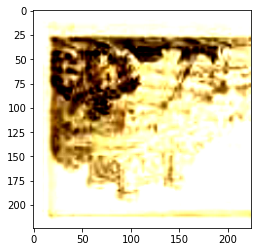

In [31]:
plt.imshow(dataset[0][0].numpy().transpose(1,2,0))

In [32]:
y_pred_no_tta = run_test_predict(model, valid_meta_df, n_tta=0)

y_pred_tta = run_test_predict(model, valid_meta_df, n_tta=10)

  0%|          | 0/1 [00:00<?, ?it/s]

run #1 times / tta=False


  0%|          | 0/10 [00:00<?, ?it/s]

run #10 times / tta=True


100%|██████████| 10/10 [00:00<00:00, 10.98it/s]


In [33]:
calculate_metrics(y_valid, y_pred_no_tta)

{'rmse': 0.9354147911071777}

In [34]:
calculate_metrics(y_valid, y_pred_tta)

{'rmse': 0.9543769359588623}

### 学習率の調整

確率的勾配法の adaptive method (ADAM / AdamW / RAdam...) は自動的に lr を調整するという目的がありますが、それ以外で手動で lr を調整すると性能が向上する場合があります。これを学習率の調整 (learning rate scheduling / scheduler) とよびます。

これまでに様々な LR Scheduing 手法が提案されています。pytorch にもいくつか実装があります。今回は3つの動きを見てみましょう。

In [35]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ExponentialLR

In [36]:
optimizer = Adam(model.parameters(), lr=1)

schedulers = [
    lambda optim: CosineAnnealingLR(optim, T_max=10),
    lambda optim: StepLR(optim, step_size=30, gamma=.2),
    lambda optim: ExponentialLR(optim, gamma=.95)
]

In [37]:
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


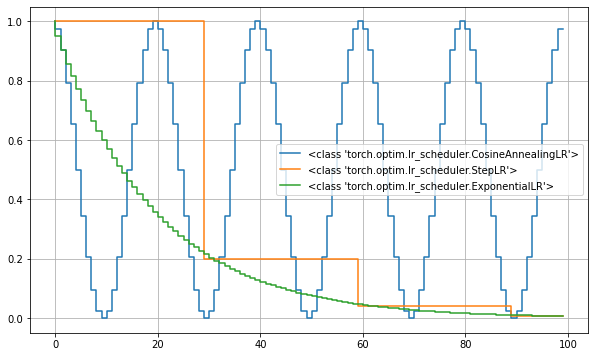

In [38]:
epochs = list(range(100))
fig, ax = plt.subplots(figsize=(10,6))

for get_scheduler in schedulers:
    rates = []
    sche = get_scheduler(Adam(model.parameters(), lr=1.))
    
    for i in epochs:
        rates.append(sche.get_last_lr()[0])
        sche.step()
        
    ax.step(epochs, rates, label=type(sche))
    
ax.grid()
ax.legend()

#### 使い方

In [39]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    n_epochs=30) -> np.ndarray:
    """
    """
    
    # 0: 
    #   : 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4
    )
    
    #   : 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=4)
    
    # optimizer の定義
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # scheduler の定義 / 10 step ごとに学習率を 0.2 倍する
    scheduler = StepLR(optimizer, step_size=10, gamma=.2, verbose=True)

    results = []
    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')
        # 1: 学習用データで学習を実行。学習時のロスを取得
        train(model, optimizer, train_loader)

        # 2: 検証データでのスコアを計算
        score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)

        print(score_valid)
        score_valid.update({
            "lr": scheduler.get_last_lr()[0]
        })
        results.append(score_valid)
        
        # scheduler の step をすすめる
        scheduler.step()
    
    return results

In [40]:
scheduled_model = create_model()
scheduled_model.to(DEVICE)

results = run_fold(
    model=scheduled_model, 
    train_df=train_meta_df.iloc[idx_tr], 
    valid_df=train_meta_df.iloc[idx_valid], 
    y_valid=train_meta_df['target'].values[idx_valid],
    n_epochs=40
)

Adjusting learning rate of group 0 to 1.0000e-03.
start 1
{'rmse': 1.2936878204345703}
Adjusting learning rate of group 0 to 1.0000e-03.
start 2
{'rmse': 0.060663819313049316}
Adjusting learning rate of group 0 to 1.0000e-03.
start 3
{'rmse': 0.39073604345321655}
Adjusting learning rate of group 0 to 1.0000e-03.
start 4
{'rmse': 0.9199904203414917}
Adjusting learning rate of group 0 to 1.0000e-03.
start 5
{'rmse': 0.622673511505127}
Adjusting learning rate of group 0 to 1.0000e-03.
start 6
{'rmse': 0.3660348653793335}
Adjusting learning rate of group 0 to 1.0000e-03.
start 7
{'rmse': 0.3975592851638794}
Adjusting learning rate of group 0 to 1.0000e-03.
start 8
{'rmse': 0.6207011938095093}
Adjusting learning rate of group 0 to 1.0000e-03.
start 9
{'rmse': 0.5616648197174072}
Adjusting learning rate of group 0 to 1.0000e-03.
start 10
{'rmse': 0.5044660568237305}
Adjusting learning rate of group 0 to 2.0000e-04.
start 11
{'rmse': 0.5017657279968262}
Adjusting learning rate of group 0 to 2

### KFold
start 38  
{'rmse': 0.8327747638899111}  
Adjusting learning rate of group 0 to 8.0000e-06.  
start 39  
{'rmse': 0.8335565631794866}  
Adjusting learning rate of group 0 to 8.0000e-06.  
start 40  
{'rmse': 0.8345181917086495}  
Adjusting learning rate of group 0 to 1.6000e-06.  
### StatifiedGroupKFold  
start 38  
{'rmse': 0.42304694652557373}  
Adjusting learning rate of group 0 to 8.0000e-06.  
start 39  
{'rmse': 0.2837718725204468}  
Adjusting learning rate of group 0 to 8.0000e-06.  
start 40  
{'rmse': 0.4705169200897217}  
Adjusting learning rate of group 0 to 1.6000e-06.  

In [41]:
log_df = pd.DataFrame(results)

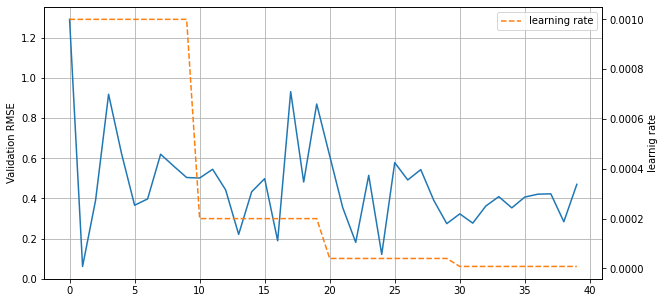

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(log_df['rmse'])
ax.grid()
ax.set_ylabel("Validation RMSE")

ax2 = ax.twinx()
ax2.plot(log_df["lr"], "--", c="C1", label="learning rate")
ax2.set_ylabel("learnig rate")
ax2.legend()

In [43]:
y_pred_no_tta = run_test_predict(scheduled_model, valid_meta_df, n_tta=0)

y_pred_tta = run_test_predict(scheduled_model, valid_meta_df, n_tta=10)

  0%|          | 0/1 [00:00<?, ?it/s]

run #1 times / tta=False


  0%|          | 0/10 [00:00<?, ?it/s]

run #10 times / tta=True


100%|██████████| 10/10 [00:01<00:00,  9.77it/s]


In [47]:
calculate_metrics(y_valid, y_pred_no_tta), calculate_metrics(y_valid, y_pred_tta)

({'rmse': 0.8345181917086495}, {'rmse': 0.8365992491281438})